In [1]:
import warnings
warnings.filterwarnings('ignore')

%load_ext autotime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import random

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import recall_score, f1_score
from scipy.sparse import csr_matrix

from implicit.als import AlternatingLeastSquares

from surprise import Dataset, Reader
import surprise.model_selection
#from surprise.model_selection import cross_validate, GridSearchCV
from surprise.prediction_algorithms import SVD, SVDpp, KNNBasic, KNNBaseline

from catboost import CatBoostClassifier, CatBoostRanker, Pool

from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k

from tqdm import tqdm

import itertools

import optuna

time: 1.64 s (started: 2024-10-26 02:07:04 +07:00)


# Читаем данные и создаем датасет

Для начала просто прочитаем данные и создадим выборку с позитивным и негативным сэмплингом:

In [2]:
events = pd.read_csv('events.csv')
item_features = pd.read_csv('item_features.csv')
user_features = pd.read_csv('user_features.csv')
ss = pd.read_csv('submission_sample.csv')

time: 144 ms (started: 2024-10-26 02:07:05 +07:00)


In [3]:
pos_sample = events[['user_id', 'item_id']].groupby('user_id', as_index = False).apply(lambda x: x.tail(3)).reset_index(drop = True)

time: 540 ms (started: 2024-10-26 02:07:05 +07:00)


In [4]:
item_ids = item_features.item_id.values
user_ids = user_features.user_id.values
combinations = list(itertools.product(user_ids, item_ids))
all_users_items = pd.DataFrame(combinations, columns=['user_id', 'item_id'])
all_users_items = all_users_items.merge(events[['user_id', 'item_id', 'rating']], how = 'left', on = ['user_id', 'item_id'])

time: 1min 2s (started: 2024-10-26 02:07:06 +07:00)


In [5]:
all_negative_items = all_users_items[all_users_items['rating'].isna()][['user_id', 'item_id']]

time: 522 ms (started: 2024-10-26 02:08:08 +07:00)


In [6]:
neg_sample = all_negative_items.groupby('user_id', as_index = False).sample(100, random_state=29)

time: 2.14 s (started: 2024-10-26 02:08:09 +07:00)


In [7]:
pos_sample['target'] = 1
neg_sample['target'] = 0
sample = pd.concat([pos_sample, neg_sample])
sample = sample.sort_values(['user_id', 'item_id'])

time: 107 ms (started: 2024-10-26 02:08:11 +07:00)


In [8]:
user_new_features = pd.DataFrame([])
user_new_features['user_id'] = np.arange(6040)
user_new_features['num_of_items'] = events.user_id.value_counts().sort_index().values

time: 10.4 ms (started: 2024-10-26 02:08:11 +07:00)


Тут создаем новые фичи: 
- количество просмотренных фильмов
- топ-3 три любимых жанра (сама фича будет выглядеть как "Принадлежит ли айтем к этому жанру")
- доля просмотров топ-3 жанров
- рейтинг фильма средний

In [9]:
events_plus_items = events.merge(item_features, how = 'left', on = 'item_id')
a = []
b = []
for user_id in tqdm(np.arange(6040)):
    sliced = events_plus_items[events_plus_items['user_id'] == user_id].mean()[4:].sort_values(ascending = False)[:3]
    v1, v2 = sliced.values.tolist(), sliced.index.tolist()
    a.append(v1)
    b.append(v2)

100%|██████████| 6040/6040 [00:04<00:00, 1280.66it/s]

time: 4.88 s (started: 2024-10-26 02:08:11 +07:00)


In [10]:
user_new_features[['fav_genre1', 'fav_genre2', 'fav_genre3']] = b
user_new_features[['fav_genre_share1', 'fav_genre_share2', 'fav_genre_share3']] = a

time: 12.5 ms (started: 2024-10-26 02:08:16 +07:00)


In [11]:
ratings = events[['item_id', 'rating']].groupby('item_id', as_index = False).mean()
ratings.columns = ['item_id', 'item_rating']

time: 30.2 ms (started: 2024-10-26 02:08:16 +07:00)


In [12]:
sample = sample.merge(ratings, how = 'left', on = 'item_id')
sample = sample.merge(user_new_features, how = 'left', on = 'user_id')
sample = sample.merge(item_features, how = 'left', on = 'item_id')
sample = sample.merge(user_features, how = 'left', on = 'user_id')

time: 443 ms (started: 2024-10-26 02:08:16 +07:00)


In [13]:
g1_arr, g2_arr, g3_arr = [], [], []
for user_id in tqdm(np.arange(6040)):
    sliced = sample[sample['user_id'] == user_id]
    if len(sliced) > 0:
        g1, g2, g3 = user_new_features[user_new_features['user_id'] == user_id][['fav_genre1', 'fav_genre2', 'fav_genre3']].values[0]
        g1_arr.append(sliced[g1].values.tolist())
        g2_arr.append(sliced[g2].values.tolist())
        g3_arr.append(sliced[g3].values.tolist())
    else:
        print('No user_id info')

100%|██████████| 6040/6040 [00:04<00:00, 1300.33it/s]

time: 4.65 s (started: 2024-10-26 02:08:16 +07:00)


In [14]:
# Создаем флаги принадлежности айтема к любимым жанрам
sample['is_fav_genre1'] = list(itertools.chain(*g1_arr))
sample['is_fav_genre2'] = list(itertools.chain(*g2_arr))
sample['is_fav_genre3'] = list(itertools.chain(*g3_arr))

time: 352 ms (started: 2024-10-26 02:08:21 +07:00)


In [15]:
del sample['fav_genre1']
del sample['fav_genre2']
del sample['fav_genre3']

time: 653 μs (started: 2024-10-26 02:08:21 +07:00)


# 1. Базовый бустинг

Базовый бустинг, подбираем гиперпараметры по 800 рандомным юзерам и среднему f1-скору (чтобы лучше учесть имбалансность таргета)

In [16]:
sbp = {'learning_rate': 0.34071414364420843, 'n_estimators': 1000, 'max_depth': 11, 'l2_leaf_reg': 5}

time: 1.67 ms (started: 2024-10-26 02:08:21 +07:00)


In [17]:
X_train, y_train = sample.drop(['user_id', 'item_id', 'target'], axis = 1), sample['target']

time: 35.8 ms (started: 2024-10-26 02:08:21 +07:00)


In [18]:
X_train, y_train = sample.drop(['user_id', 'item_id', 'target'], axis = 1), sample['target']

clf = CatBoostClassifier(
    **sbp,
    loss_function='CrossEntropy', 
    cat_features=['gender'], 
    early_stopping_rounds=100,
    random_state=29,
    silent=True
)

clf.fit(X_train, y_train, verbose=100)

0:	learn: 0.2970932	total: 107ms	remaining: 1m 46s
100:	learn: 0.0850726	total: 14s	remaining: 2m 4s
200:	learn: 0.0710382	total: 26.3s	remaining: 1m 44s
300:	learn: 0.0606037	total: 38.5s	remaining: 1m 29s
400:	learn: 0.0525387	total: 50.9s	remaining: 1m 16s
500:	learn: 0.0459637	total: 1m 3s	remaining: 1m 3s
600:	learn: 0.0402470	total: 1m 15s	remaining: 50.2s
700:	learn: 0.0361247	total: 1m 27s	remaining: 37.4s
800:	learn: 0.0323999	total: 1m 40s	remaining: 25s
900:	learn: 0.0293025	total: 1m 58s	remaining: 13s
999:	learn: 0.0268830	total: 2m 13s	remaining: 0us


time: 2min 13s (started: 2024-10-26 02:08:21 +07:00)


In [19]:
scoring = {'f1_score': 'f1',
           'roc_auc_score': 'roc_auc',
           'pr_auc_score': 'average_precision'}

cv_metrics_v1 = cross_validate(clf, X_train, y_train, scoring=scoring, cv=3)
print(f"F1-score: {np.round(np.mean(cv_metrics_v1['test_f1_score']), 4)}")
print(f"ROC-AUC: {np.round(np.mean(cv_metrics_v1['test_roc_auc_score']), 4)}")
print(f"PR-AUC: {np.round(np.mean(cv_metrics_v1['test_pr_auc_score']), 4)}")

F1-score: 0.0984
ROC-AUC: 0.7627
PR-AUC: 0.136
time: 5min 34s (started: 2024-10-26 02:10:35 +07:00)


Ну, для базовой штуки неплохо, создадим топ-10 рекомендаций и сохраним:

In [20]:
combinations = list(itertools.product(user_ids, item_ids))
data_for_pred = pd.DataFrame(combinations, columns=['user_id', 'item_id'])
data_for_pred = data_for_pred.merge(ratings, how = 'left', on = 'item_id')
data_for_pred = data_for_pred.merge(user_new_features[['user_id', 'num_of_items', 'fav_genre_share1', 'fav_genre_share2', 'fav_genre_share3']], how = 'left', on = 'user_id')
data_for_pred = data_for_pred.merge(item_features, how = 'left', on = 'item_id')
data_for_pred = data_for_pred.merge(user_features, how = 'left', on = 'user_id')

g1_arr, g2_arr, g3_arr = [], [], []
for user_id in tqdm(np.arange(6040)):
    sliced = data_for_pred[data_for_pred['user_id'] == user_id]
    if len(sliced) > 0:
        g1, g2, g3 = user_new_features[user_new_features['user_id'] == user_id][['fav_genre1', 'fav_genre2', 'fav_genre3']].values[0]
        g1_arr.append(sliced[g1].values.tolist())
        g2_arr.append(sliced[g2].values.tolist())
        g3_arr.append(sliced[g3].values.tolist())
    else:
        print('No user_id info')

data_for_pred['is_fav_genre1'] = list(itertools.chain(*g1_arr))
data_for_pred['is_fav_genre2'] = list(itertools.chain(*g2_arr))
data_for_pred['is_fav_genre3'] = list(itertools.chain(*g3_arr))

events_c = events[['user_id', 'item_id']]
events_c['target'] = 1
data_for_pred = data_for_pred.merge(events_c, how = 'left', on = ['user_id', 'item_id'])

data_for_pred['target'] = data_for_pred['target'].fillna(0)

data_for_pred['catboost_score'] = clf.predict_proba(data_for_pred.drop(['user_id', 'item_id', 'target'], axis = 1))[:, 1]

100%|██████████| 6040/6040 [01:37<00:00, 62.27it/s]


time: 3min 50s (started: 2024-10-26 02:16:10 +07:00)


In [21]:
items_to_recommend = data_for_pred[data_for_pred['target'] == 0][['user_id', 'item_id', 'catboost_score']].copy()
items_to_recommend = items_to_recommend.sort_values(['user_id', 'catboost_score'], ascending = [True, False]).reset_index(drop = True)
items_to_recommend = items_to_recommend.groupby('user_id', as_index = False).apply(lambda x: x.nlargest(10, 'catboost_score')).reset_index(drop=True)

time: 31.1 s (started: 2024-10-26 02:20:00 +07:00)


In [22]:
ss_new = items_to_recommend[['user_id', 'item_id']].groupby('user_id', as_index = False)['item_id'].apply(lambda x: ' '.join(map(str, x)))

time: 79.5 ms (started: 2024-10-26 02:20:31 +07:00)


In [23]:
ss_new.to_csv('submission_sample_v1.csv', index = False)

time: 16.2 ms (started: 2024-10-26 02:20:31 +07:00)


In [24]:
del items_to_recommend
del ss_new

time: 874 μs (started: 2024-10-26 02:20:31 +07:00)


# 2. Бустинг с ALS

Теперь построим ALS с помощью библиотеки **implicit** в другом ноутбуке:

In [25]:
als_df = pd.read_csv('als_score.csv')

time: 5.12 s (started: 2024-10-26 02:20:31 +07:00)


In [26]:
sample = sample.merge(als_df, how = 'left', on = ['user_id', 'item_id'])

time: 5.79 s (started: 2024-10-26 02:20:37 +07:00)


In [27]:
X_train, y_train = sample.drop(['user_id', 'item_id', 'target'], axis = 1), sample['target']

clf = CatBoostClassifier(
    **sbp,
    loss_function='CrossEntropy', 
    cat_features=['gender'], 
    early_stopping_rounds=100,
    random_state=29,
    silent=True
)

clf.fit(X_train, y_train, verbose=100)

0:	learn: 0.1402405	total: 111ms	remaining: 1m 50s
100:	learn: 0.0305409	total: 14.7s	remaining: 2m 11s
200:	learn: 0.0205187	total: 29.1s	remaining: 1m 55s
300:	learn: 0.0148740	total: 43.3s	remaining: 1m 40s
400:	learn: 0.0110217	total: 58s	remaining: 1m 26s
500:	learn: 0.0082990	total: 1m 12s	remaining: 1m 11s
600:	learn: 0.0066671	total: 1m 26s	remaining: 57.3s
700:	learn: 0.0053996	total: 1m 40s	remaining: 43s
800:	learn: 0.0043605	total: 1m 55s	remaining: 28.6s
900:	learn: 0.0036327	total: 2m 10s	remaining: 14.3s
999:	learn: 0.0030785	total: 2m 24s	remaining: 0us


time: 2min 25s (started: 2024-10-26 02:20:42 +07:00)


In [28]:
scoring = {'f1_score': 'f1',
           'roc_auc_score': 'roc_auc',
           'pr_auc_score': 'average_precision'}

cv_metrics_v2 = cross_validate(clf, X_train, y_train, scoring=scoring, cv=3)
print(f"F1-score: {np.round(np.mean(cv_metrics_v2['test_f1_score']), 4)}")
print(f"ROC-AUC: {np.round(np.mean(cv_metrics_v2['test_roc_auc_score']), 4)}")
print(f"PR-AUC: {np.round(np.mean(cv_metrics_v2['test_pr_auc_score']), 4)}")

F1-score: 0.608
ROC-AUC: 0.9716
PR-AUC: 0.6738
time: 5min 34s (started: 2024-10-26 02:23:08 +07:00)


Тут сильно взлетел PR-AUC, что очень хорошо

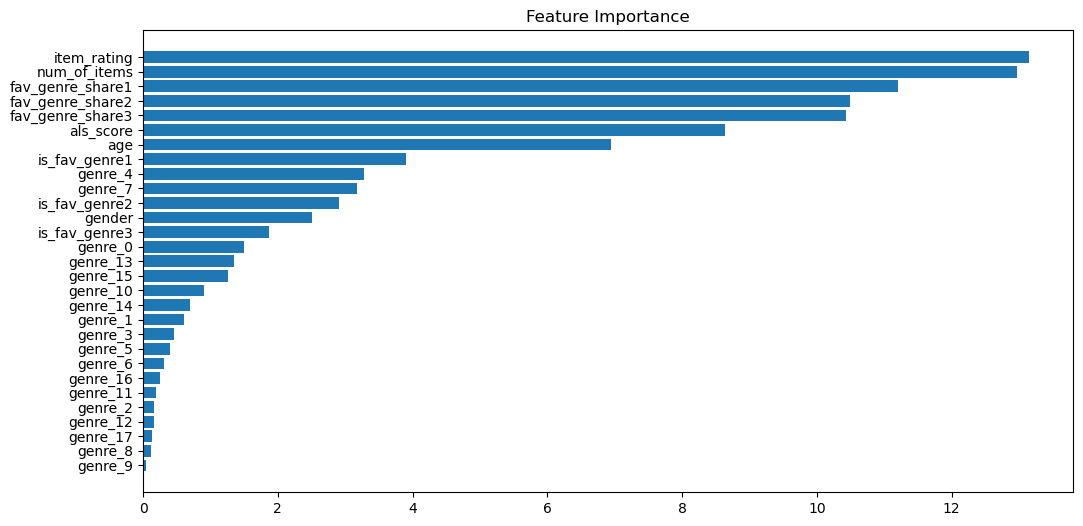

time: 1.38 s (started: 2024-10-26 02:28:42 +07:00)


In [29]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [30]:
try:
    del data_for_pred['catboost_score']
except:
    pass
data_for_pred = data_for_pred.merge(als_df, how = 'left', on = ['user_id', 'item_id'])
data_for_pred['catboost_score'] = clf.predict_proba(data_for_pred.drop(['user_id', 'item_id', 'target'], axis = 1))[:, 1]

time: 52.1 s (started: 2024-10-26 02:28:43 +07:00)


In [31]:
items_to_recommend = data_for_pred[data_for_pred['target'] == 0][['user_id', 'item_id', 'catboost_score']].copy()
items_to_recommend = items_to_recommend.sort_values(['user_id', 'catboost_score'], ascending = [True, False]).reset_index(drop = True)
items_to_recommend = items_to_recommend.groupby('user_id', as_index = False).apply(lambda x: x.nlargest(10, 'catboost_score')).reset_index(drop=True)

time: 34.2 s (started: 2024-10-26 02:29:35 +07:00)


In [32]:
ss_new = items_to_recommend[['user_id', 'item_id']].groupby('user_id', as_index = False)['item_id'].apply(lambda x: ' '.join(map(str, x)))

time: 92.7 ms (started: 2024-10-26 02:30:10 +07:00)


In [33]:
ss_new.to_csv('submission_sample_v2.csv', index = False)

time: 18.3 ms (started: 2024-10-26 02:30:10 +07:00)


In [34]:
del items_to_recommend
del ss_new

time: 1.26 ms (started: 2024-10-26 02:30:10 +07:00)


# 3. Бустинг с ALS + SVD + kNN

Теперь попробуем библиотеку **surprise**, оттуда возьмем коллаборативную фильтрацию с моделями SVD и kNN (по юзерам и по айтемам)

In [35]:
knn_scores = pd.read_csv('surprise_scores.csv')

time: 5.41 s (started: 2024-10-26 02:30:10 +07:00)


In [36]:
sample = sample.merge(knn_scores, how = 'left', on = ['user_id', 'item_id'])

time: 3.53 s (started: 2024-10-26 02:30:15 +07:00)


In [37]:
sbp = {'learning_rate': 0.3, 'n_estimators': 1000, 'max_depth': 12, 'l2_leaf_reg': 5}

X_train, y_train = sample.drop(['user_id', 'item_id', 'target'], axis = 1), sample['target']

clf = CatBoostClassifier(
    **sbp,
    loss_function='CrossEntropy', 
    cat_features=['gender'], 
    early_stopping_rounds=100,
    random_state=29,
    silent=True
)

clf.fit(X_train, y_train, verbose=100)

0:	learn: 0.1721537	total: 167ms	remaining: 2m 46s
100:	learn: 0.0256997	total: 22.4s	remaining: 3m 19s
200:	learn: 0.0156957	total: 43.1s	remaining: 2m 51s
300:	learn: 0.0099690	total: 1m 4s	remaining: 2m 30s
400:	learn: 0.0067387	total: 1m 30s	remaining: 2m 14s
500:	learn: 0.0048624	total: 1m 50s	remaining: 1m 49s
600:	learn: 0.0037318	total: 2m 10s	remaining: 1m 26s
700:	learn: 0.0029489	total: 2m 35s	remaining: 1m 6s
800:	learn: 0.0023665	total: 2m 58s	remaining: 44.3s
900:	learn: 0.0019536	total: 3m 21s	remaining: 22.1s
999:	learn: 0.0016589	total: 3m 41s	remaining: 0us


time: 3min 41s (started: 2024-10-26 02:30:19 +07:00)


In [38]:
scoring = {'f1_score': 'f1',
           'roc_auc_score': 'roc_auc',
           'pr_auc_score': 'average_precision'}

cv_metrics_v3 = cross_validate(clf, X_train, y_train, scoring=scoring, cv=3)
print(f"F1-score: {np.round(np.mean(cv_metrics_v3['test_f1_score']), 4)}")
print(f"ROC-AUC: {np.round(np.mean(cv_metrics_v3['test_roc_auc_score']), 4)}")
print(f"PR-AUC: {np.round(np.mean(cv_metrics_v3['test_pr_auc_score']), 4)}")

F1-score: 0.6127
ROC-AUC: 0.9744
PR-AUC: 0.6843
time: 5min 19s (started: 2024-10-26 02:34:01 +07:00)


Ну тут SVD скор хороший, kNN слабо себя показал

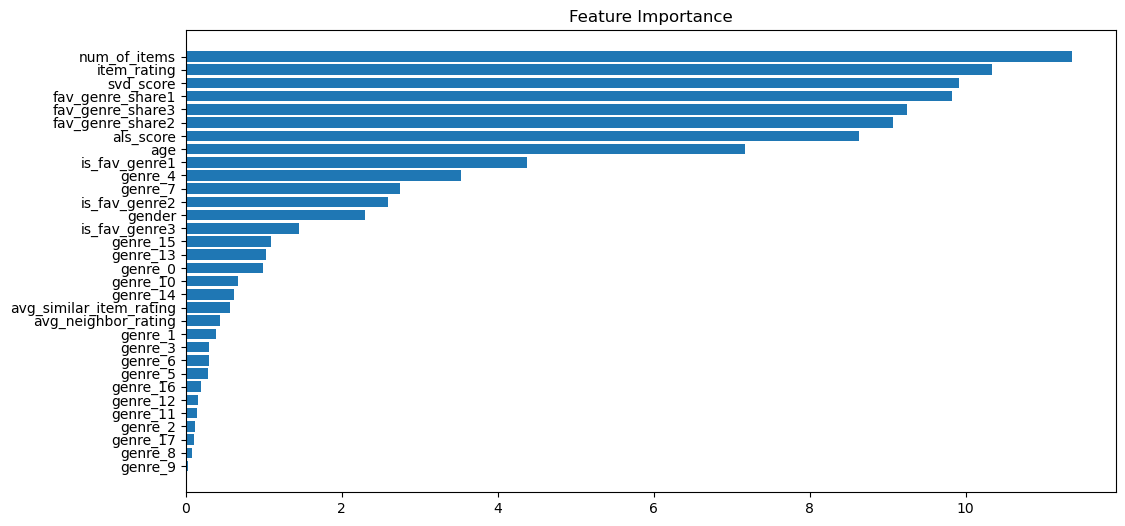

time: 125 ms (started: 2024-10-26 02:39:20 +07:00)


In [39]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [40]:
try:
    del data_for_pred['catboost_score']
except:
    pass
data_for_pred = data_for_pred.merge(knn_scores, how = 'left', on = ['user_id', 'item_id'])
data_for_pred['catboost_score'] = clf.predict_proba(data_for_pred.drop(['user_id', 'item_id', 'target'], axis = 1))[:, 1]

time: 28.6 s (started: 2024-10-26 02:39:20 +07:00)


In [41]:
items_to_recommend = data_for_pred[data_for_pred['target'] == 0][['user_id', 'item_id', 'catboost_score']].copy()
items_to_recommend = items_to_recommend.sort_values(['user_id', 'catboost_score'], ascending = [True, False]).reset_index(drop = True)
items_to_recommend = items_to_recommend.groupby('user_id', as_index = False).apply(lambda x: x.nlargest(10, 'catboost_score')).reset_index(drop=True)

time: 25.4 s (started: 2024-10-26 02:39:49 +07:00)


In [42]:
ss_new = items_to_recommend[['user_id', 'item_id']].groupby('user_id', as_index = False)['item_id'].apply(lambda x: ' '.join(map(str, x)))

time: 47.5 ms (started: 2024-10-26 02:40:14 +07:00)


In [43]:
ss_new.to_csv('submission_sample_v3.csv', index = False)

time: 9.14 ms (started: 2024-10-26 02:40:14 +07:00)


In [44]:
del items_to_recommend
del ss_new

time: 297 μs (started: 2024-10-26 02:40:14 +07:00)


# 4. Попробуем еще implicit скоры

**implicit** мне больше понравился, возьмем оттуда еще модели и проранжируем айтемы:

In [45]:
implicit_scores = pd.read_csv('implicit_scores.csv')

time: 9.94 s (started: 2024-10-26 02:40:14 +07:00)


In [46]:
sample = sample.drop('als_score', axis = 1)
sample = sample.merge(implicit_scores, how = 'left', on = ['user_id', 'item_id'])

time: 4.23 s (started: 2024-10-26 02:40:24 +07:00)


In [47]:
sbp = {'learning_rate': 0.3, 'n_estimators': 500, 'max_depth': 12, 'l2_leaf_reg': 5}

X_train, y_train = sample.drop(['user_id', 'item_id', 'target'], axis = 1), sample['target']

clf = CatBoostClassifier(
    **sbp,
    loss_function='CrossEntropy', 
    cat_features=['gender'], 
    early_stopping_rounds=100,
    random_state=29,
    silent=True
)

clf.fit(X_train, y_train, verbose=100)

0:	learn: 0.2223832	total: 133ms	remaining: 1m 6s
100:	learn: 0.0201961	total: 12.9s	remaining: 50.8s
200:	learn: 0.0101192	total: 26.1s	remaining: 38.9s
300:	learn: 0.0057325	total: 38.7s	remaining: 25.6s
400:	learn: 0.0035865	total: 51.5s	remaining: 12.7s
499:	learn: 0.0024429	total: 1m 4s	remaining: 0us


time: 1min 5s (started: 2024-10-26 02:40:29 +07:00)


In [48]:
scoring = {'f1_score': 'f1',
           'roc_auc_score': 'roc_auc',
           'pr_auc_score': 'average_precision'}

cv_metrics_v5 = cross_validate(clf, X_train, y_train, scoring=scoring, cv=3)
print(f"F1-score: {np.round(np.mean(cv_metrics_v5['test_f1_score']), 4)}")
print(f"ROC-AUC: {np.round(np.mean(cv_metrics_v5['test_roc_auc_score']), 4)}")
print(f"PR-AUC: {np.round(np.mean(cv_metrics_v5['test_pr_auc_score']), 4)}")

F1-score: 0.6422
ROC-AUC: 0.9833
PR-AUC: 0.7299
time: 2min 43s (started: 2024-10-26 02:41:34 +07:00)


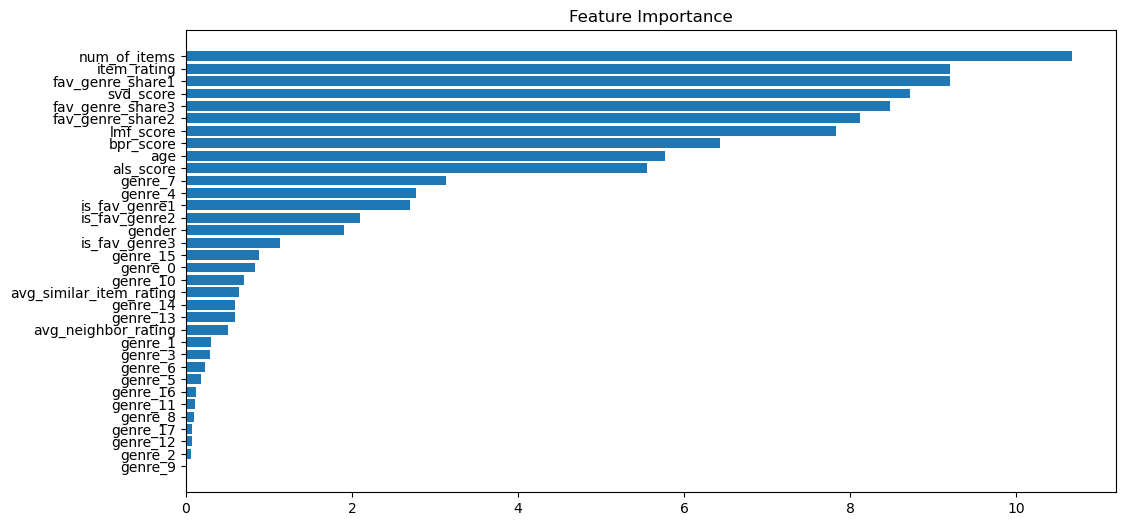

time: 131 ms (started: 2024-10-26 02:44:17 +07:00)


In [49]:
feature_importance = clf.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

Тут скоры хорошо залетели, конечно, они частично скореллированы с ALS, но бустинг переживет

In [50]:
data_for_pred = data_for_pred.drop(['als_score'], axis = 1)

time: 3.23 s (started: 2024-10-26 02:44:18 +07:00)


In [51]:
try:
    del data_for_pred['catboost_score']
except:
    pass

data_for_pred = data_for_pred.merge(implicit_scores, how = 'left', on = ['user_id', 'item_id'])
data_for_pred['catboost_score'] = clf.predict_proba(data_for_pred.drop(['user_id', 'item_id', 'target'], axis = 1))[:, 1]

time: 28.7 s (started: 2024-10-26 02:44:21 +07:00)


In [52]:
items_to_recommend = data_for_pred[data_for_pred['target'] == 0][['user_id', 'item_id', 'catboost_score']].copy()
items_to_recommend = items_to_recommend.sort_values(['user_id', 'catboost_score'], ascending = [True, False]).reset_index(drop = True)
items_to_recommend = items_to_recommend.groupby('user_id', as_index = False).apply(lambda x: x.nlargest(10, 'catboost_score')).reset_index(drop=True)

time: 25.7 s (started: 2024-10-26 02:44:50 +07:00)


In [53]:
ss_new = items_to_recommend[['user_id', 'item_id']].groupby('user_id', as_index = False)['item_id'].apply(lambda x: ' '.join(map(str, x)))

time: 88.2 ms (started: 2024-10-26 02:45:15 +07:00)


In [54]:
ss_new.to_csv('submission_sample_v555.csv', index = False)

time: 18.9 ms (started: 2024-10-26 02:45:15 +07:00)


In [55]:
del items_to_recommend
del ss_new

time: 641 μs (started: 2024-10-26 02:45:15 +07:00)


## Отбор признаков

И последнее: отберем признаки, чтобы оставить только самое важное, и уменьшим глубину деревьев в бустинге

In [56]:
selector = SelectFromModel(clf, threshold="0.5*mean", prefit=True)
X_selected = selector.transform(X_train)

selected_features = X_train.columns[selector.get_support()]
print(selected_features)

X_train_selected = X_train[selected_features]

Index(['item_rating', 'num_of_items', 'fav_genre_share1', 'fav_genre_share2',
       'fav_genre_share3', 'genre_4', 'genre_7', 'gender', 'age',
       'is_fav_genre1', 'is_fav_genre2', 'svd_score', 'als_score', 'bpr_score',
       'lmf_score'],
      dtype='object')
time: 536 ms (started: 2024-10-26 02:45:15 +07:00)


In [57]:
sbp = {'n_estimators': 1200, 'max_depth': 7, 'l2_leaf_reg': 10}

time: 142 μs (started: 2024-10-26 02:45:16 +07:00)


In [58]:
clf1 = CatBoostClassifier(
    **sbp,
    learning_rate=0.1,
    loss_function='CrossEntropy', 
    cat_features=['gender'], 
    early_stopping_rounds=100,
    random_state=29,
    silent=True
)

clf1.fit(X_train_selected, y_train, verbose=100)

0:	learn: 0.4438528	total: 34.9ms	remaining: 41.8s
100:	learn: 0.0430016	total: 3.84s	remaining: 41.8s
200:	learn: 0.0411535	total: 7.6s	remaining: 37.8s
300:	learn: 0.0396797	total: 11.2s	remaining: 33.6s
400:	learn: 0.0384444	total: 15.2s	remaining: 30.3s
500:	learn: 0.0372419	total: 19.3s	remaining: 26.9s
600:	learn: 0.0361780	total: 22.8s	remaining: 22.7s
700:	learn: 0.0351977	total: 26.5s	remaining: 18.9s
800:	learn: 0.0342700	total: 30.6s	remaining: 15.3s
900:	learn: 0.0334268	total: 34.4s	remaining: 11.4s
1000:	learn: 0.0326434	total: 37.9s	remaining: 7.53s
1100:	learn: 0.0319141	total: 41.3s	remaining: 3.71s
1199:	learn: 0.0311524	total: 44.8s	remaining: 0us


time: 45.1 s (started: 2024-10-26 02:45:16 +07:00)


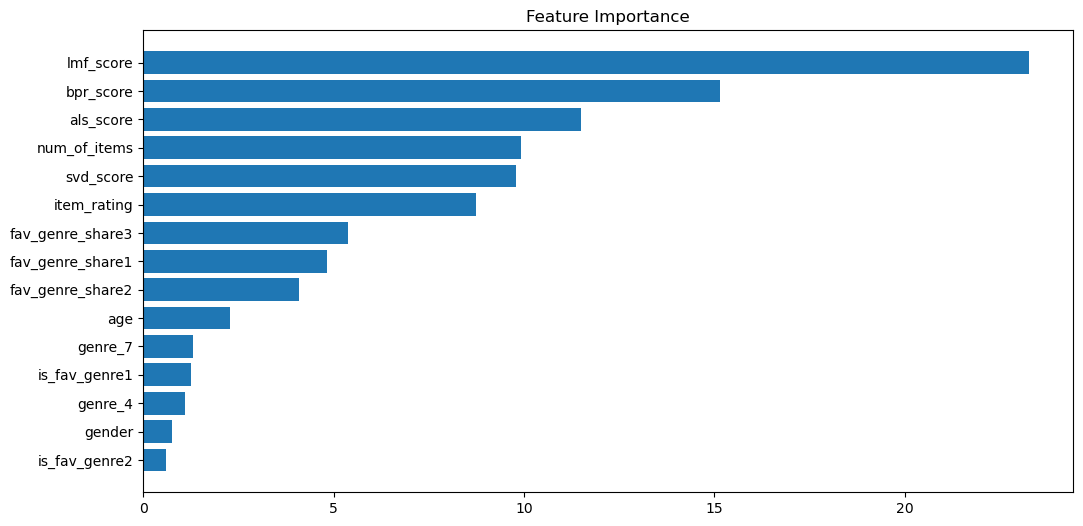

time: 80.2 ms (started: 2024-10-26 02:46:01 +07:00)


In [59]:
feature_importance = clf1.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_train_selected.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

Топ-признаки: три скора из **implicit**, кол-во просмотренных фильмов, скор SVD и рейтинг айтема
Базовые признаки не в почете

In [60]:
scoring = {'f1_score': 'f1',
           'roc_auc_score': 'roc_auc',
           'pr_auc_score': 'average_precision'}

cv_metrics_v4 = cross_validate(clf1, X_train_selected, y_train, scoring=scoring, cv=3)
print(f"F1-score: {np.round(np.mean(cv_metrics_v4['test_f1_score']), 4)}")
print(f"ROC-AUC: {np.round(np.mean(cv_metrics_v4['test_roc_auc_score']), 4)}")
print(f"PR-AUC: {np.round(np.mean(cv_metrics_v4['test_pr_auc_score']), 4)}")

F1-score: 0.6473
ROC-AUC: 0.9858
PR-AUC: 0.7434
time: 1min 33s (started: 2024-10-26 02:46:01 +07:00)


Кросс-валидационные метрики очень приятные

In [61]:
data_for_pred['catboost_score'] = clf1.predict_proba(data_for_pred[selected_features])[:, 1]

time: 14.3 s (started: 2024-10-26 02:47:35 +07:00)


In [62]:
items_to_recommend = data_for_pred[data_for_pred['target'] == 0][['user_id', 'item_id', 'catboost_score']].copy()
items_to_recommend = items_to_recommend.sort_values(['user_id', 'catboost_score'], ascending = [True, False]).reset_index(drop = True)
items_to_recommend = items_to_recommend.groupby('user_id', as_index = False).apply(lambda x: x.nlargest(10, 'catboost_score')).reset_index(drop=True)

time: 23.6 s (started: 2024-10-26 02:47:49 +07:00)


In [63]:
ss_new = items_to_recommend[['user_id', 'item_id']].groupby('user_id', as_index = False)['item_id'].apply(lambda x: ' '.join(map(str, x)))

time: 50.8 ms (started: 2024-10-26 02:48:13 +07:00)


In [64]:
ss_new.to_csv('submission_sample_556.csv', index = False)

time: 8.94 ms (started: 2024-10-26 02:48:13 +07:00)


Метрики: 
- базовый бустинг - Recall@10 = 0.0412
- catboost + als - Recall@10 = 0.0908
- catboost + als + svd + kNN - Recall@10 = 0.0882
- catboost + als + svd + kNN + lmf + bpr - Recall@10 = 0.1054 (после отбора признаков)